In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVC1UAE/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVC1UAE/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVC1UAE/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Get Tokenizer



```
tokenizer = info.features['text'].encoder
```



In [2]:
# Get the tokenizer
tokenizer = info.features['text'].encoder

In [3]:
# Print description of features
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

## Prepare the dataset

You can then get the train and test splits and generate padded batches.

*Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use `256` and this takes roughly a minute to train per epoch. In the video, Laurence used `16` which takes around 4 minutes per epoch.*

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'],

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
##padded_batch


Like `tf.data.Dataset.batch`, the components of the resulting element will have an additional outer dimension, which will be batch_size (or N % batch_size for the last element if batch_size does not divide the number of input elements N evenly and drop_remainder is False). If your program depends on the batches having the same outer dimension, you should set the drop_remainder argument to True to prevent the smaller batch from being produced.

Unlike `tf.data.Dataset.batch`, the input elements to be batched may have different shapes, and this transformation will pad each component to the respective shape in padded_shapes. The padded_shapes argument determines the resulting shape for each dimension of each component in an output element:


In [5]:
tokenizer.vocab_size

8185

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM, GlobalAveragePooling1D, GRU, Conv1D
from tensorflow.keras import Sequential

## 1- GlobalAveragePooling1D

In [7]:

embedding_dim = 64
dense_dim = 64

model_globalAveragePooling1D =  Sequential([
        Embedding(tokenizer.vocab_size, embedding_dim),
        GlobalAveragePooling1D(),
        Dense(dense_dim, activation = "relu"),
        Dense(1, activation = "sigmoid")])


model_globalAveragePooling1D.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

model_globalAveragePooling1D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          523840    
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 528065 (2.01 MB)
Trainable params: 528065 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
num_epochs = 20
history_global = model_globalAveragePooling1D.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 29s 232ms/step - loss: 0.6914 - accuracy: 0.5311 - val_loss: 0.6865 - val_accuracy: 0.6008
Epoch 2/20
98/98 [==============================] - 14s 141ms/step - loss: 0.6587 - accuracy: 0.6660 - val_loss: 0.6179 - val_accuracy: 0.6842
Epoch 3/20
98/98 [==============================] - 12s 122ms/step - loss: 0.5392 - accuracy: 0.7856 - val_loss: 0.4842 - val_accuracy: 0.8153
Epoch 4/20
98/98 [==============================] - 10s 102ms/step - loss: 0.4131 - accuracy: 0.8452 - val_loss: 0.3971 - val_accuracy: 0.8493
Epoch 5/20
98/98 [==============================] - 7s 68ms/step - loss: 0.3352 - accuracy: 0.8827 - val_loss: 0.3523 - val_accuracy: 0.8646
Epoch 6/20
98/98 [==============================] - 8s 77ms/step - loss: 0.2875 - accuracy: 0.8992 - val_loss: 0.3312 - val_accuracy: 0.8701
Epoch 7/20
98/98 [==============================] - 6s 53ms/step - loss: 0.2587 - accuracy: 0.9078 - val_loss: 0.3186 - val_accuracy: 0.8750
Epoch

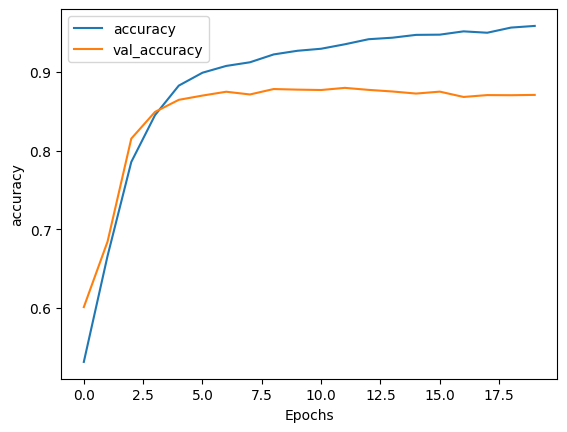

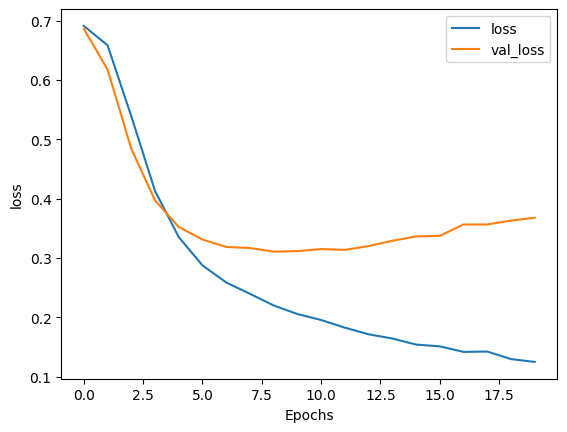

In [9]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history_global, "accuracy")
plot_graphs(history_global, "loss")

## 2-Single LSTM

In [10]:
# Hyperparameters
embedding_dim = 64
lstm_dim = 64
dense_dim = 64

# Build single lstm model
# tokenizer.vocab_size

model_singleLSTM = Sequential([
    Embedding(tokenizer.vocab_size, embedding_dim), # (tokenizer.vocab_size x embedding_dim)
    Bidirectional(LSTM(lstm_dim)),
    Dense(dense_dim, activation = "relu"),
    Dense(1, activation = "sigmoid")
])


model_singleLSTM.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ["accuracy"])

model_singleLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598209 (2.28 MB)
Trainable params: 598209 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
NUM_EPOCHS = 20

history_singleLSTM = model_singleLSTM.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 37s 327ms/step - loss: 0.6181 - accuracy: 0.6598 - val_loss: 0.5460 - val_accuracy: 0.7838
Epoch 2/20
98/98 [==============================] - 28s 284ms/step - loss: 0.4667 - accuracy: 0.8114 - val_loss: 0.6552 - val_accuracy: 0.6625
Epoch 3/20
98/98 [==============================] - 32s 327ms/step - loss: 0.5107 - accuracy: 0.7620 - val_loss: 0.4864 - val_accuracy: 0.7780
Epoch 4/20
98/98 [==============================] - 24s 241ms/step - loss: 0.3727 - accuracy: 0.8522 - val_loss: 0.4550 - val_accuracy: 0.7994
Epoch 5/20
98/98 [==============================] - 24s 241ms/step - loss: 0.3473 - accuracy: 0.8656 - val_loss: 0.4672 - val_accuracy: 0.8020
Epoch 6/20
98/98 [==============================] - 23s 229ms/step - loss: 0.3105 - accuracy: 0.8835 - val_loss: 0.4659 - val_accuracy: 0.8024
Epoch 7/20
98/98 [==============================] - 23s 230ms/step - loss: 0.2721 - accuracy: 0.9027 - val_loss: 0.4650 - val_accuracy: 0.8081

In [12]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model_singleLSTM.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(8185, 64)


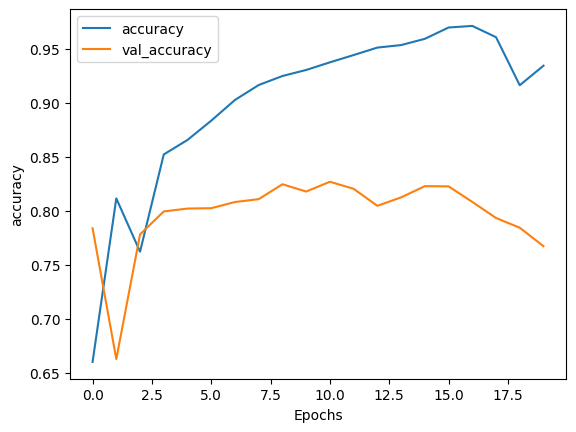

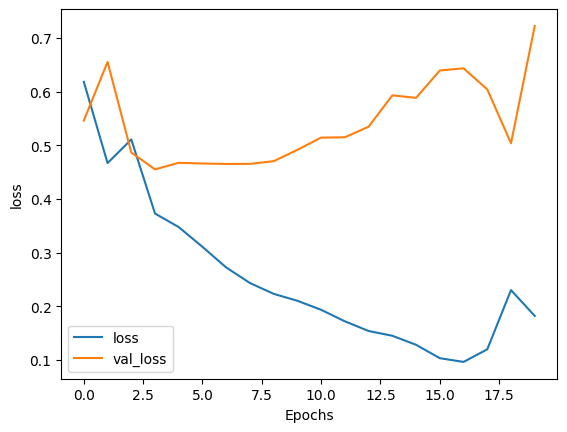

In [13]:
# Plot the accuracy and results
plot_graphs(history_singleLSTM, "accuracy")
plot_graphs(history_singleLSTM, "loss")

## 3-Multiple LSTM

In [14]:
embedding_dim = 64
lstm_dim1 = 64
lstm_dim2 = 32
dense_dim = 64

model_multipleLSTM = Sequential([
    Embedding(tokenizer.vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_dim1, return_sequences = True)),
    Bidirectional(LSTM(lstm_dim2)),
    Dense(64, activation = "relu"),
    Dense(1, activation = "sigmoid")
])
model_multipleLSTM.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

model_multipleLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635329 (2.42 MB)
Trainable params: 63532

In [15]:
NUM_EPOCHS = 20

# Train the model
history_multipleLSTM = model_multipleLSTM.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 58s 516ms/step - loss: 0.5649 - accuracy: 0.6970 - val_loss: 0.4819 - val_accuracy: 0.7938
Epoch 2/20
98/98 [==============================] - 45s 458ms/step - loss: 0.3906 - accuracy: 0.8395 - val_loss: 0.4026 - val_accuracy: 0.8364
Epoch 3/20
98/98 [==============================] - 44s 448ms/step - loss: 0.2915 - accuracy: 0.8873 - val_loss: 0.4130 - val_accuracy: 0.8373
Epoch 4/20
98/98 [==============================] - 42s 425ms/step - loss: 0.3084 - accuracy: 0.8791 - val_loss: 0.4087 - val_accuracy: 0.8350
Epoch 5/20
98/98 [==============================] - 42s 427ms/step - loss: 0.2233 - accuracy: 0.9194 - val_loss: 0.3702 - val_accuracy: 0.8502
Epoch 6/20
98/98 [==============================] - 40s 409ms/step - loss: 0.1758 - accuracy: 0.9390 - val_loss: 0.4221 - val_accuracy: 0.8423
Epoch 7/20
98/98 [==============================] - 41s 411ms/step - loss: 0.1527 - accuracy: 0.9462 - val_loss: 0.5011 - val_accuracy: 0.8412

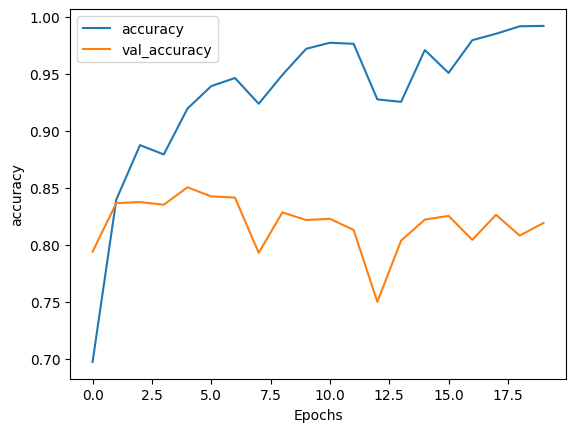

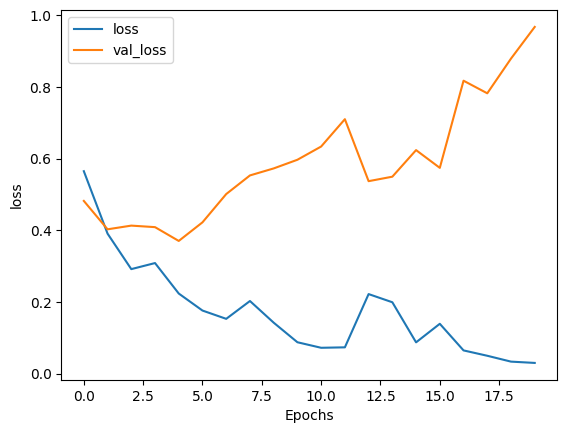

In [16]:

# Plot the accuracy and results
plot_graphs(history_multipleLSTM, "accuracy")
plot_graphs(history_multipleLSTM, "loss")

## 4-GRU

In [18]:
embedding_dim = 16
gru_dim = 32
dense_dim = 6

model_gru = Sequential([
    Embedding(tokenizer.vocab_size, embedding_dim),
    Bidirectional(GRU(gru_dim)),
    Dense(dense_dim, activation = "relu"),
    Dense(1, activation = "sigmoid")
])

model_gru.compile(loss = "binary_crossentropy",
                  optimizer = "adam",
                  metrics = ["accuracy"])
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          130960    
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 390       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 140957 (550.61 KB)
Trainable params: 140957 (550.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(train_dataset, epochs=NUM_EPOCHS, batch_size = BATCH_SIZE,validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 34s 297ms/step - loss: 0.6914 - accuracy: 0.5292 - val_loss: 0.6654 - val_accuracy: 0.6412
Epoch 2/20
98/98 [==============================] - 25s 253ms/step - loss: 0.6174 - accuracy: 0.6710 - val_loss: 0.5706 - val_accuracy: 0.7010
Epoch 3/20
98/98 [==============================] - 22s 226ms/step - loss: 0.3994 - accuracy: 0.8223 - val_loss: 0.5089 - val_accuracy: 0.7723
Epoch 4/20
98/98 [==============================] - 21s 209ms/step - loss: 0.2997 - accuracy: 0.8842 - val_loss: 0.4370 - val_accuracy: 0.8077
Epoch 5/20
98/98 [==============================] - 18s 176ms/step - loss: 0.2637 - accuracy: 0.9006 - val_loss: 0.4687 - val_accuracy: 0.8155
Epoch 6/20
98/98 [==============================] - 16s 161ms/step - loss: 0.2281 - accuracy: 0.9175 - val_loss: 0.4839 - val_accuracy: 0.8105
Epoch 7/20
98/98 [==============================] - 17s 172ms/step - loss: 0.2053 - accuracy: 0.9292 - val_loss: 0.5045 - val_accuracy: 0.8066

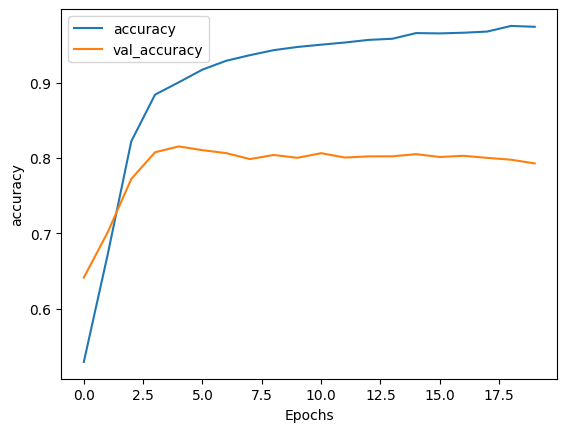

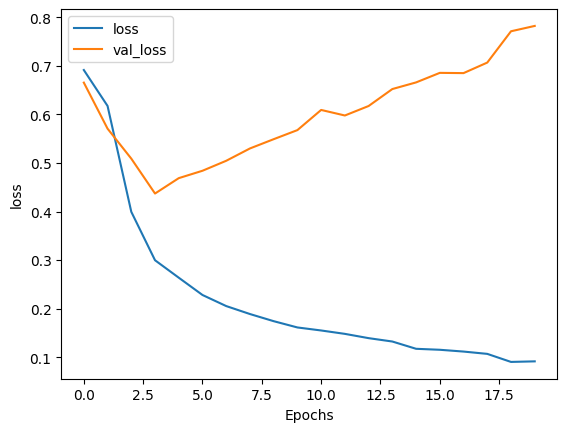

In [20]:

# Plot the accuracy and results
plot_graphs(history_gru, "accuracy")
plot_graphs(history_gru, "loss")

## Conv1D

In [24]:
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

model_conv1d = Sequential([
    Embedding(tokenizer.vocab_size, embedding_dim),
    Conv1D(filters, kernel_size, activation = "relu"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv1d.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv1d.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 16)          130960    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         10368     
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 6)                 774       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 142109 (555.11 KB)
Trainable params: 142109 (555.11 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [25]:
NUM_EPOCHS = 20

history_conv = model_conv1d.fit(train_dataset, epochs=NUM_EPOCHS, batch_size = BATCH_SIZE,validation_data=test_dataset)

Epoch 1/20
98/98 [==============================] - 57s 508ms/step - loss: 0.6862 - accuracy: 0.5548 - val_loss: 0.6587 - val_accuracy: 0.6879
Epoch 2/20
98/98 [==============================] - 22s 226ms/step - loss: 0.5215 - accuracy: 0.8043 - val_loss: 0.4089 - val_accuracy: 0.8462
Epoch 3/20
98/98 [==============================] - 15s 151ms/step - loss: 0.3225 - accuracy: 0.8834 - val_loss: 0.3340 - val_accuracy: 0.8682
Epoch 4/20
98/98 [==============================] - 14s 139ms/step - loss: 0.2506 - accuracy: 0.9116 - val_loss: 0.3180 - val_accuracy: 0.8744
Epoch 5/20
98/98 [==============================] - 11s 115ms/step - loss: 0.2130 - accuracy: 0.9260 - val_loss: 0.3127 - val_accuracy: 0.8777
Epoch 6/20
98/98 [==============================] - 9s 87ms/step - loss: 0.1868 - accuracy: 0.9358 - val_loss: 0.3174 - val_accuracy: 0.8776
Epoch 7/20
98/98 [==============================] - 8s 82ms/step - loss: 0.1664 - accuracy: 0.9430 - val_loss: 0.3399 - val_accuracy: 0.8734
Epo

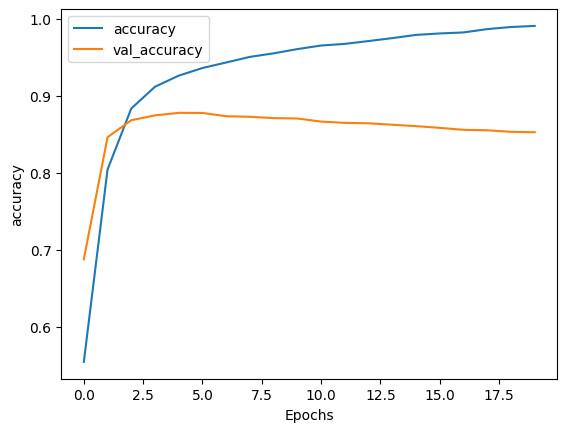

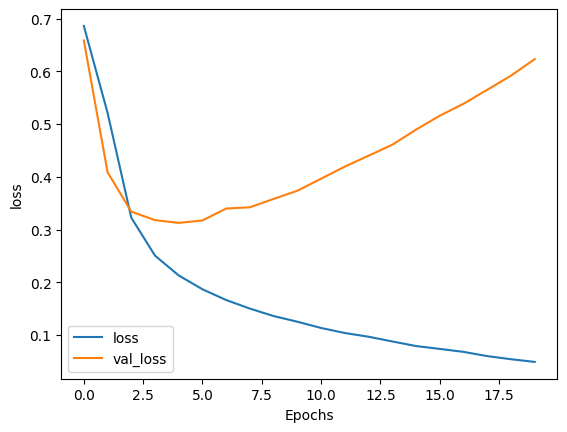

In [26]:

# Plot the accuracy and results
plot_graphs(history_conv, "accuracy")
plot_graphs(history_conv, "loss")